### Imports

In [1]:


import os
import argparse
from pathlib import Path
from typing import Optional, Tuple


import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import torchaudio
import torchvision.transforms as T


from transformers import (
AutoImageProcessor,
AutoModelForImageClassification,
get_linear_schedule_with_warmup,
)


from sklearn.model_selection import train_test_split


try:
   from tqdm import tqdm
except Exception:
   tqdm = lambda x: x

c:\Users\Yani\Documents\Wild_fires_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset Class: Audio to Mel-Spectrogram (ViT Ready)

In [2]:
class ESC2SpectrogramDataset(Dataset):
    def __init__(self, df, audio_dir, image_processor,
                 target_sr=22050, n_mels=128, n_fft=1024, hop_length=512,
                 duration=5.0, top_db=80.0):
        self.df = df.reset_index(drop=True)
        self.audio_dir = audio_dir
        self.image_processor = image_processor
        self.target_sr = target_sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.duration = duration
        self.max_samples = int(target_sr * duration)
        self.top_db = top_db

        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=target_sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
        )
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB(top_db=top_db)
        self.to_pil = T.ToPILImage()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wav_path = os.path.join(self.audio_dir, row["filename"])
        label = int(row["target"])

        mel_db_scaled = self._compute_mel(wav_path)

        pil_img = self.to_pil(mel_db_scaled.unsqueeze(0)).convert("RGB")
        processed = self.image_processor(images=pil_img, return_tensors="pt")
        pixel_values = processed["pixel_values"].squeeze(0)

        return pixel_values, label

    def _compute_mel(self, wav_path):
        waveform, sr = torchaudio.load(wav_path)

        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        if sr != self.target_sr:
            waveform = torchaudio.transforms.Resample(sr, self.target_sr)(waveform)

        if waveform.shape[1] < self.max_samples:
            pad = self.max_samples - waveform.shape[1]
            waveform = F.pad(waveform, (0, pad))
        else:
            waveform = waveform[:, :self.max_samples]

        mel_spec = self.mel_transform(waveform)
        mel_db = self.amplitude_to_db(mel_spec).clamp(min=-self.top_db, max=0.0)
        mel_db_scaled = (mel_db + self.top_db) / self.top_db

        return mel_db_scaled.squeeze(0)


### Utility Functions: Collate, Accuracy, and Evaluation

In [3]:
def collate_fn(batch):
    pixel_values = torch.stack([x[0] for x in batch])
    labels = torch.tensor([x[1] for x in batch], dtype=torch.long)
    return {"pixel_values": pixel_values, "labels": labels}

def compute_accuracy(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

def evaluate(model, dataloader, device):
    model.eval()
    total_loss, total_acc, n = 0, 0, 0
    with torch.no_grad():
        for batch in dataloader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            bs = pixel_values.size(0)
            total_loss += loss.item() * bs
            total_acc += compute_accuracy(logits, labels) * bs
            n += bs
    return total_loss / n, total_acc / n


### Training loop : Fine-Tuning ViT on ESC Dataset

In [4]:
def train_loop(model, train_loader, val_loader, device, epochs=5, lr=5e-5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
    )

    scaler = torch.cuda.amp.GradScaler() if device.type == "cuda" else None

    for epoch in range(1, epochs+1):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch}")
        for batch in loop:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(pixel_values=pixel_values, labels=labels)
                    loss = outputs.loss
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(pixel_values=pixel_values, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

            scheduler.step()
            loop.set_postfix(loss=loss.item())

        val_loss, val_acc = evaluate(model, val_loader, device)
        print(f"Epoch {epoch}: val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")


### Setup: Data Split, Model Initialization, and Loaders

In [5]:
# Paths

csv_path = r"C:\Users\Yani\Documents\audio_data\audio_data\meta\esc2.csv"
audio_dir = r"C:\Users\Yani\Documents\audio_data\audio_data\audio"



# Load metadata
df = pd.read_csv(csv_path)


train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["target"], random_state=42)

# Hugging Face model + processor
model_name = "google/vit-base-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=2,ignore_mismatched_sizes=True)

# Freeze backbone (only train classifier head)
for param in model.vit.parameters():
    param.requires_grad = False 

print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Total parameters:", sum(p.numel() for p in model.parameters()))
# Datasets + loaders
train_ds = ESC2SpectrogramDataset(train_df, audio_dir, image_processor)
val_ds = ESC2SpectrogramDataset(val_df, audio_dir, image_processor)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 1538
Total parameters: 85800194


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [23]:
train_loop(model, train_loader, val_loader, device, epochs=5, lr=5e-5)


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

c:\Users\Yani\Documents\Wild_fires_project\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
Epoch 1: 100%|██████████| 196/196 [20:01<00:00,  6.13s/it, loss=0.373]


Epoch 1: val_loss=0.5110, val_acc=0.7844


Epoch 2: 100%|██████████| 196/196 [25:52<00:00,  7.92s/it, loss=0.32] 


Epoch 2: val_loss=0.4312, val_acc=0.8253


Epoch 3: 100%|██████████| 196/196 [15:47<00:00,  4.83s/it, loss=0.359]


Epoch 3: val_loss=0.3956, val_acc=0.8457


Epoch 4: 100%|██████████| 196/196 [18:01<00:00,  5.52s/it, loss=0.297]


Epoch 4: val_loss=0.3784, val_acc=0.8546


Epoch 5: 100%|██████████| 196/196 [19:59<00:00,  6.12s/it, loss=0.49] 


Epoch 5: val_loss=0.3731, val_acc=0.8546


### Visualization: Mel-Spectrogram Example

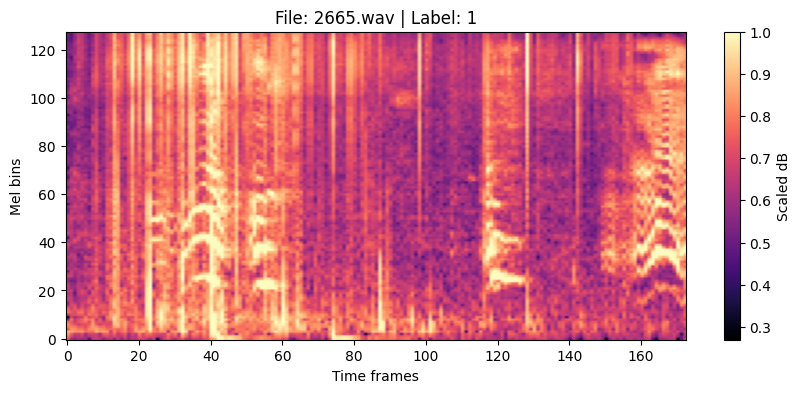

In [31]:
def show_mel_spectrogram(dataset, idx=0):
    row = dataset.df.iloc[idx]
    wav_path = os.path.join(dataset.audio_dir, row["filename"])
    label = row["target"]

    mel = dataset._compute_mel(wav_path)

    plt.figure(figsize=(10, 4))
    plt.imshow(mel.numpy(), origin="lower", aspect="auto", cmap="magma")
    plt.colorbar(label="Scaled dB")
    plt.title(f"File: {row['filename']} | Label: {label}")
    plt.xlabel("Time frames")
    plt.ylabel("Mel bins")
    plt.show()

# Example
show_mel_spectrogram(train_ds, idx=6)

### Visualization: ViT RGB Input Example

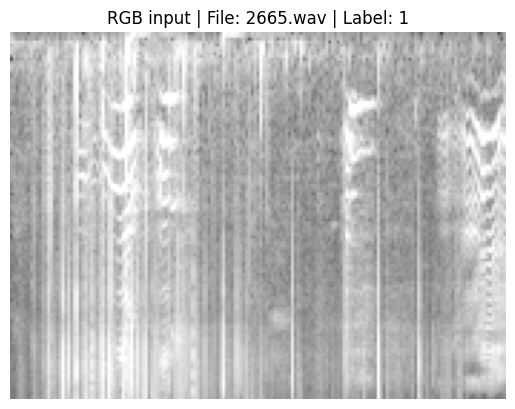

In [33]:
def show_rgb_input(dataset, idx=0):
    row = dataset.df.iloc[idx]
    wav_path = os.path.join(dataset.audio_dir, row["filename"])
    mel = dataset._compute_mel(wav_path)

    pil_img = dataset.to_pil(mel.unsqueeze(0)).convert("RGB")
    plt.imshow(pil_img)
    plt.title(f"RGB input | File: {row['filename']} | Label: {row['target']}")
    plt.axis("off")
    plt.show()

# Example
show_rgb_input(train_ds, idx=6)


In [34]:
# Total files labeled 1 in the full dataset
num_fire = df['target'].sum()
print(f"Number of files labeled 1 (fire): {num_fire} out of {len(df)}")

# Optional: in training and validation subsets
num_fire_train = train_df['target'].sum()
num_fire_val = val_df['target'].sum()
print(f"Training set: {num_fire_train} fire files out of {len(train_df)}")
print(f"Validation set: {num_fire_val} fire files out of {len(val_df)}")


Number of files labeled 1 (fire): 1960 out of 3920
Training set: 1568 fire files out of 3136
Validation set: 392 fire files out of 784
